In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from model import build_model
import tqdm
from data import load_data
import matplotlib.pyplot as plt
from model import Generator, Descriminator


In [9]:
def evaluate(generator: Generator, descriminator: Descriminator, test_loader, num_data, batch_size, device):
    generator.eval()
    descriminator.eval()
    progress_bar = tqdm.tqdm(test_loader)
    generator_losses = []
    descriminator_losses = []
    for i, (images, _) in enumerate(progress_bar):
      with torch.no_grad():
          real_img_batch = images.to(device)
          fake_img_batch = generator(batch_size)
            
          real_labels = torch.ones(size=(batch_size, ), device=device)
          fake_labels = torch.zeros(size=(batch_size, ), device=device) 
            
          # Descriminate
          real_desc_pred = descriminator(real_img_batch).squeeze() # (5, 1)
          fake_desc_pred = descriminator(fake_img_batch).squeeze() # Descrimating Generated image
            
          real_desc_loss = F.binary_cross_entropy(real_desc_pred, real_labels)
          fake_desc_loss = F.binary_cross_entropy(fake_desc_pred, fake_labels)
          descriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
          
          fake_img_batch = generator(batch_size)
          fake_desc_pred = descriminator(fake_img_batch).squeeze()
          generator_loss = F.binary_cross_entropy(fake_desc_pred, real_labels)
          
          generator_losses.append(generator_loss.item())
          descriminator_losses.append(descriminator_loss.item())
          
      if i == num_data:
          break
    
    eval_generator_mean_loss = torch.tensor(generator_losses).mean()
    eval_descriminator_mean_loss = torch.tensor(descriminator_losses).mean()
    
    img = generator(1).squeeze().detach().cpu()
    plt.imshow(img, cmap='gray')
    plt.title("Generated Image")
    plt.axis("off")
    plt.show()
    
    generator.train()
    descriminator.train()
    
    return eval_descriminator_mean_loss, eval_generator_mean_loss
 
def train(generator, descriminator, num_epochs, eval_epoch, device, batch_size):
   
    
    generator.to(device)
    descriminator.to(device)
    descriminator_optimizer = torch.optim.AdamW(descriminator.parameters(), lr=1e-5, weight_decay=0.001, betas=(0.5, 0.999))
    generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
    train_loader, test_loader = load_data(train_batch_size=batch_size, test_batch_size=2)
    
    
    for epoch in range(num_epochs):
        progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
        generator.train()
        descriminator.train()
        progress.set_description(f'Epoch: {epoch}')
        generator_losses = []
        descriminator_losses = []
        
        for images, _ in progress:
            real_img_batch = images.to(device)
            fake_img_batch = generator(batch_size)
            
            real_labels = torch.ones(size=(batch_size, ), device=device)
            fake_labels = torch.zeros(size=(batch_size, ), device=device)
            
            # Descriminate
            real_desc_pred = descriminator(real_img_batch).squeeze() # (5, 1)
            fake_desc_pred = descriminator(fake_img_batch).squeeze() # Descrimating Generated image
            
            real_desc_loss = F.binary_cross_entropy(real_desc_pred, real_labels)
            fake_desc_loss = F.binary_cross_entropy(fake_desc_pred, fake_labels)
            descriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0

            descriminator_optimizer.zero_grad()
            descriminator_loss.backward()
            descriminator_optimizer.step()
            
            
            generator_optimizer.zero_grad()
            fake_img_batch = generator(batch_size)
            fake_desc_pred = descriminator(fake_img_batch).squeeze()
            
            generator_loss = F.binary_cross_entropy(fake_desc_pred, real_labels)
            generator_loss.backward()
            generator_optimizer.step()
            
            
            generator_losses.append(generator_loss.item())
            descriminator_losses.append(descriminator_loss.item())
            
            progress.set_postfix({'generator_loss': f"{generator_loss.item():.4f}", 'descriminator_loss': f"{descriminator_loss.item():.4f}"})
            
      
        generator_mean_loss = torch.tensor(generator_losses).mean()
        descriminator_mean_loss = torch.tensor(descriminator_losses).mean()
       
        eval_descriminator_loss, eval_generator_loss = evaluate(generator, descriminator,test_loader, num_data=20, batch_size=2, device=device)
        progress.set_postfix({'generator_loss': f"{generator_mean_loss:.5f}", 'descriminator_loss': f"{descriminator_mean_loss:.5f}", 'eval_gen_loss': f"{eval_generator_loss:.5f}", 'eval_des_loss':f"{eval_descriminator_loss:.4f}"})
       
      
          
    

In [10]:
# def evaluate(generator: Generator, discriminator: Descriminator, test_loader, num_data, batch_size, device):
#     generator.eval()
#     discriminator.eval()
#     progress_bar = tqdm.tqdm(test_loader)
#     generator_losses = []
#     discriminator_losses = []
#     for i, (images, _) in enumerate(progress_bar):
#         with torch.no_grad():
#             real_img_batch = images.to(device)
#             fake_img_batch = generator(batch_size)
            
#             real_labels = torch.ones(size=(batch_size, ), device=device)
#             fake_labels = torch.zeros(size=(batch_size, ), device=device)
            
#             # Discriminate
#             real_desc_pred = discriminator(real_img_batch).squeeze()
#             fake_desc_pred = discriminator(fake_img_batch).squeeze()
            
#             real_desc_loss = F.binary_cross_entropy_with_logits(real_desc_pred, real_labels)
#             fake_desc_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, fake_labels)
#             discriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
            
#             # Generator evaluation
#             fake_img_batch = generator(batch_size)
#             fake_desc_pred = discriminator(fake_img_batch).squeeze()
#             generator_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, real_labels)
            
#             generator_losses.append(generator_loss.item())
#             discriminator_losses.append(discriminator_loss.item())
            
#         if i >= num_data:  # Use >= instead of ==
#             break
    
#     eval_generator_mean_loss = torch.tensor(generator_losses).mean()
#     eval_discriminator_mean_loss = torch.tensor(discriminator_losses).mean()
    
#     img = generator(1).squeeze().detach().cpu()
#     plt.imshow(img, cmap='gray')
#     plt.title("Generated Image")
#     plt.axis("off")
#     plt.show()
    
#     generator.train()
#     discriminator.train()
    
#     return eval_discriminator_mean_loss, eval_generator_mean_loss

# def train(generator, discriminator, num_epochs, eval_epoch, device, batch_size):
#     generator.to(device)
#     discriminator.to(device)
    
#     # Different learning rates - often helps with stability
#     discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
#     generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
#     train_loader, test_loader = load_data(train_batch_size=batch_size, test_batch_size=2)
    
#     for epoch in range(num_epochs):
#         progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
#         generator.train()
#         discriminator.train()
#         progress.set_description(f'Epoch: {epoch}')
#         generator_losses = []
#         discriminator_losses = []
        
#         for images, _ in progress:
#             real_img_batch = images.to(device)
#             batch_size_actual = real_img_batch.size(0)  # Handle variable batch sizes
            
#             real_labels = torch.ones(size=(batch_size_actual,), device=device) + 0.3 * torch.randn(size=(batch_size_actual,), device=device)
#             fake_labels = torch.zeros(size=(batch_size_actual,), device=device) - 0.3 * torch.randn(size=(batch_size_actual,), device=device)
            
#             # === Train Discriminator ===
#             discriminator_optimizer.zero_grad()
            
#             # Real images
#             real_desc_pred = discriminator(real_img_batch).squeeze()
#             real_desc_loss = F.binary_cross_entropy_with_logits(real_desc_pred, real_labels)
            
#             # Fake images (detach to prevent generator gradients)
#             fake_img_batch = generator(batch_size_actual)
#             fake_desc_pred = discriminator(fake_img_batch).squeeze()
#             fake_desc_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, fake_labels)
            
#             discriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
#             discriminator_loss.backward()
#             discriminator_optimizer.step()
            
#             # === Train Generator ===
#             generator_optimizer.zero_grad()
            
#             # Generate new fake images (don't detach - we want gradients)
#             fake_img_batch = generator(batch_size_actual)
#             fake_desc_pred = discriminator(fake_img_batch).squeeze()
#             generator_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, real_labels)
            
#             generator_loss.backward()
#             generator_optimizer.step()
            
#             generator_losses.append(generator_loss.item())
#             discriminator_losses.append(discriminator_loss.item())
            
#             progress.set_postfix({
#                 'gen_loss': f"{generator_loss.item():.4f}", 
#                 'disc_loss': f"{discriminator_loss.item():.4f}"
#             })
        
#         generator_mean_loss = torch.tensor(generator_losses).mean()
#         discriminator_mean_loss = torch.tensor(discriminator_losses).mean()
        
#         if epoch > 1:
#             eval_discriminator_loss, eval_generator_loss = evaluate(
#                 generator, discriminator, test_loader, num_data=20, batch_size=2, device=device
#             )
#             progress.set_postfix({
#                 'gen_loss': f"{generator_mean_loss:.4f}", 
#                 'disc_loss': f"{discriminator_mean_loss:.4f}", 
#                 'eval_gen': f"{eval_generator_loss:.4f}", 
#                 'eval_disc': f"{eval_discriminator_loss:.4f}"
#             })
#         else:
#             progress.set_postfix({
#                 'gen_loss': f"{generator_mean_loss:.4f}", 
#                 'disc_loss': f"{discriminator_mean_loss:.4f}"
#             })

  0%|          | 20/5000 [00:00<00:18, 269.24it/s]


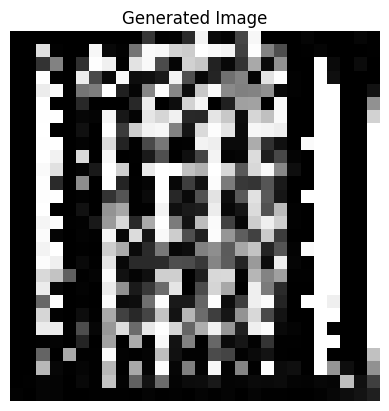

  0%|          | 20/5000 [00:00<00:21, 227.55it/s]


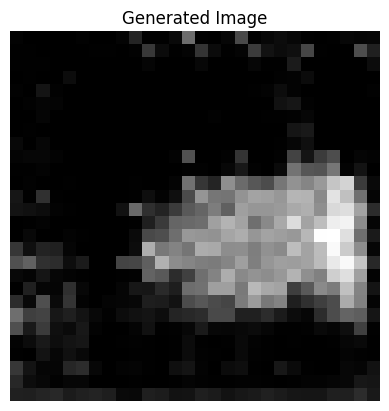

  0%|          | 20/5000 [00:00<00:27, 178.35it/s]


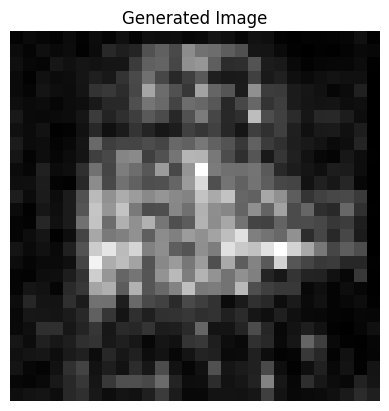

  0%|          | 20/5000 [00:00<00:20, 243.91it/s]


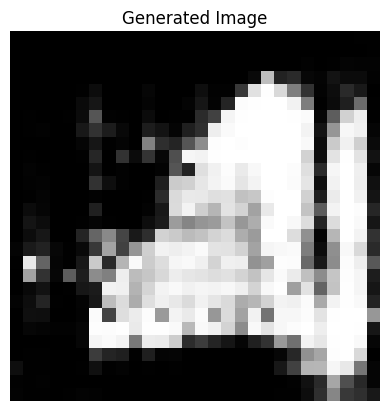

  0%|          | 20/5000 [00:00<00:21, 232.92it/s]


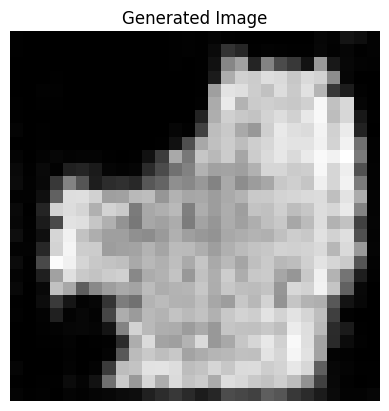

  0%|          | 20/5000 [00:00<00:19, 259.36it/s]


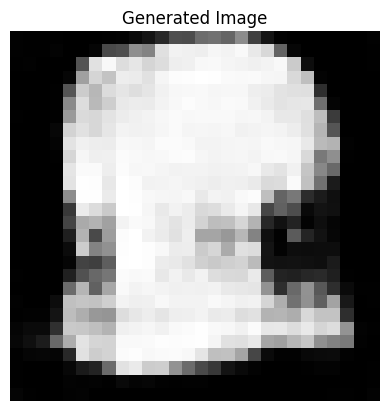

  0%|          | 20/5000 [00:00<00:23, 216.40it/s]


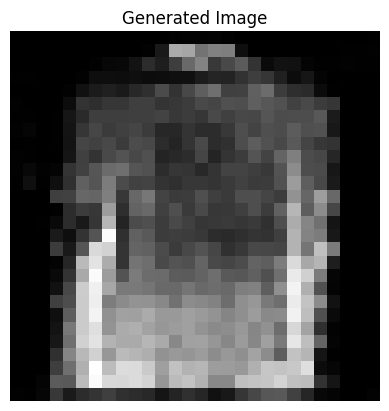

  0%|          | 20/5000 [00:00<00:19, 252.07it/s]


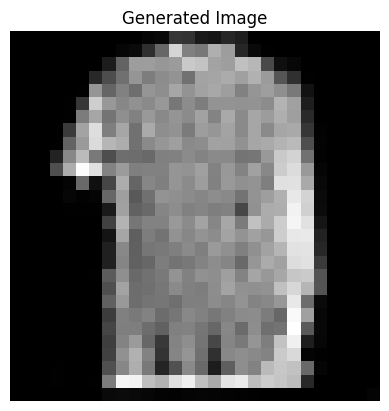

  0%|          | 20/5000 [00:00<00:22, 219.39it/s]


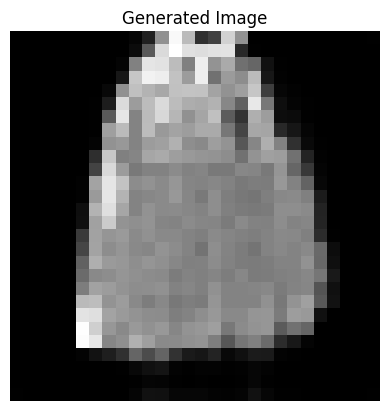

  0%|          | 20/5000 [00:00<00:20, 238.10it/s]


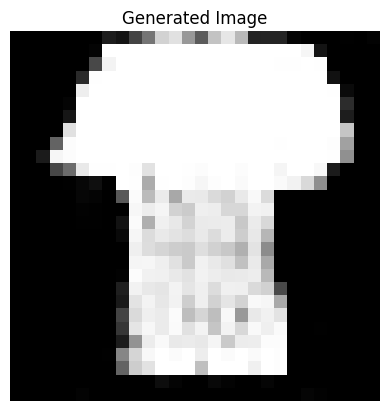

  0%|          | 20/5000 [00:00<00:21, 228.91it/s]


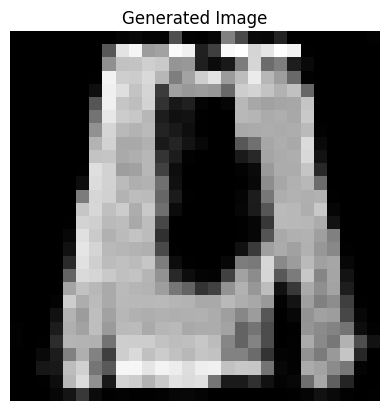

  0%|          | 20/5000 [00:00<00:21, 236.85it/s]


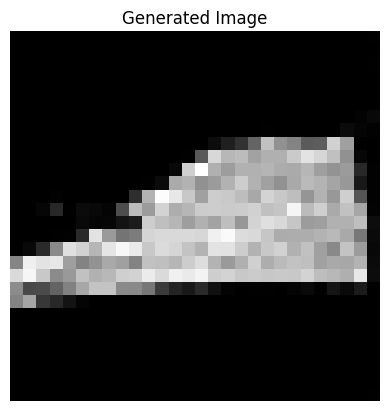

  0%|          | 20/5000 [00:00<00:22, 218.33it/s]


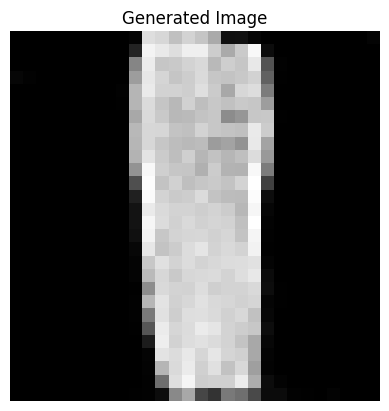

  0%|          | 20/5000 [00:00<00:21, 227.29it/s]


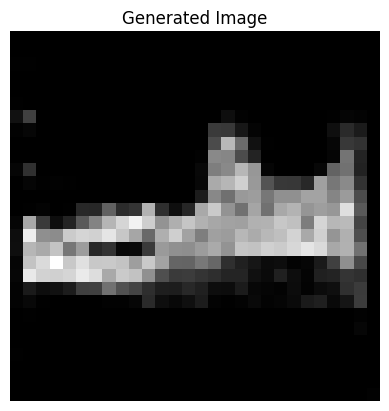

  0%|          | 20/5000 [00:00<00:20, 243.91it/s]


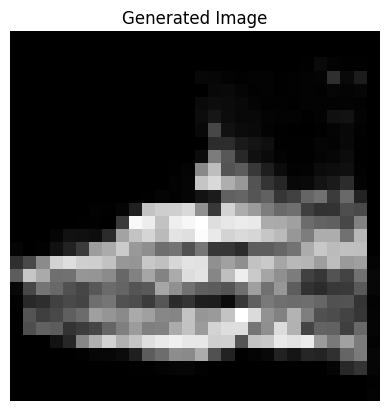

  0%|          | 20/5000 [00:00<00:20, 244.21it/s]


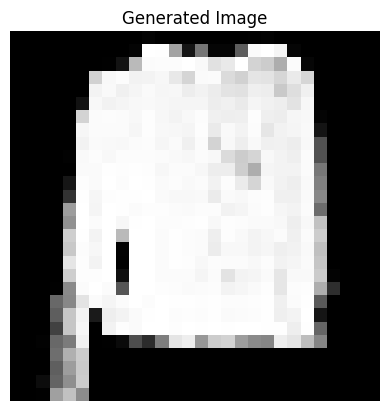

  0%|          | 20/5000 [00:00<00:20, 240.57it/s]


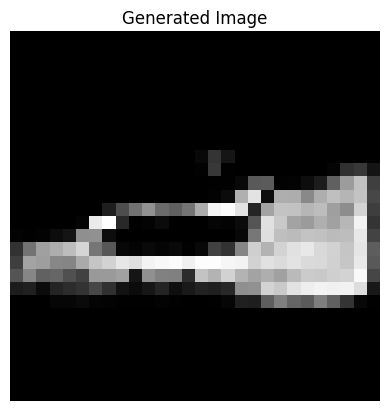

  0%|          | 20/5000 [00:00<00:21, 236.09it/s]


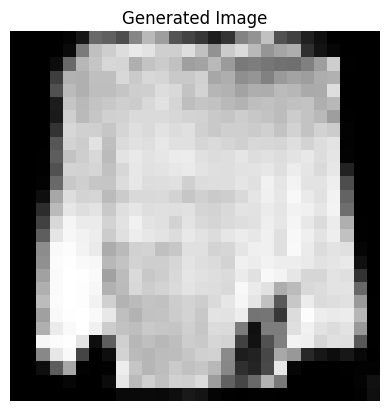

  0%|          | 20/5000 [00:00<00:19, 250.40it/s]


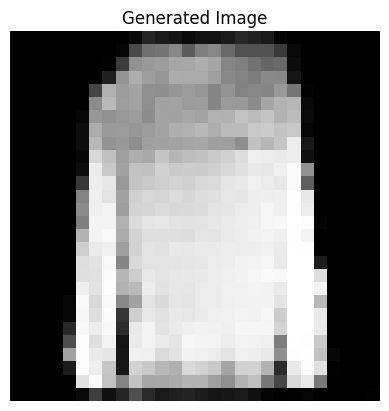

  0%|          | 20/5000 [00:00<00:20, 240.25it/s]


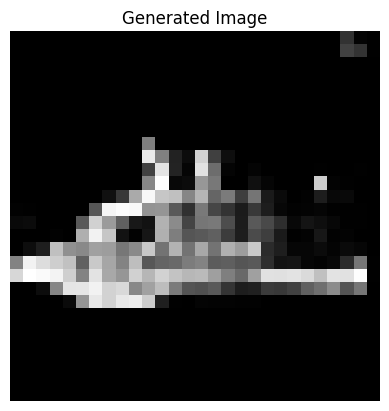

  0%|          | 20/5000 [00:00<00:18, 268.06it/s]


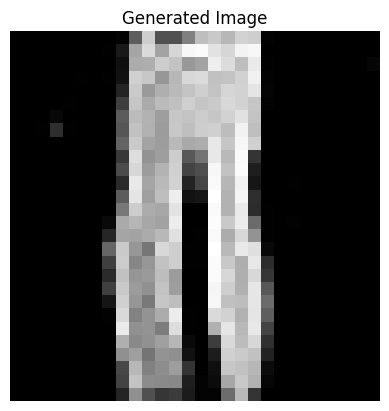

  0%|          | 20/5000 [00:00<00:23, 210.54it/s]


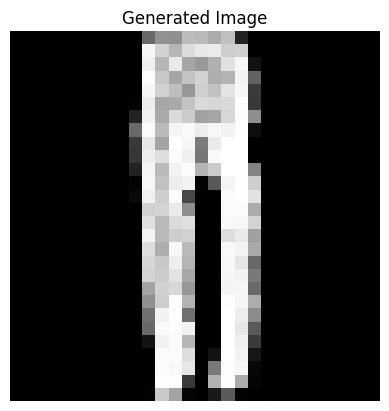

  0%|          | 20/5000 [00:00<00:18, 262.55it/s]


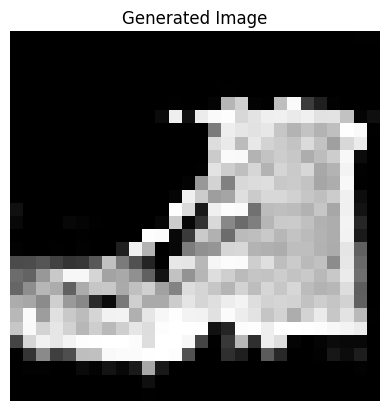

  0%|          | 20/5000 [00:00<00:19, 259.69it/s]


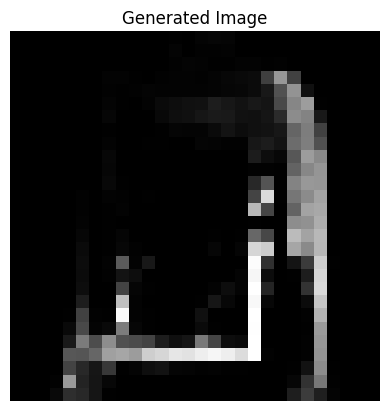

  0%|          | 20/5000 [00:00<00:21, 229.40it/s]


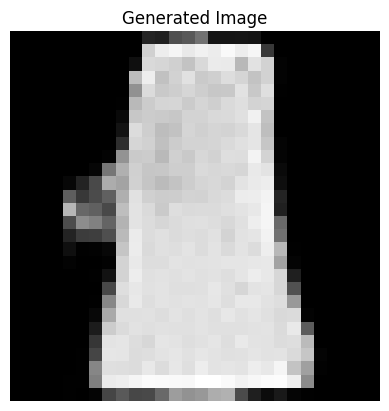

  0%|          | 20/5000 [00:00<00:20, 243.91it/s]


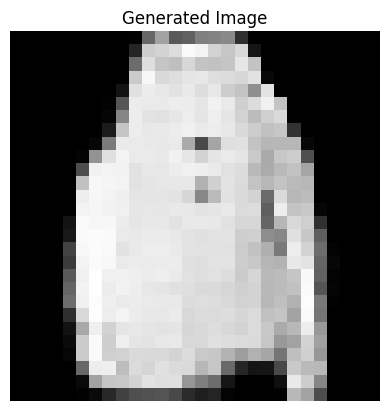

  0%|          | 20/5000 [00:00<00:19, 250.00it/s]


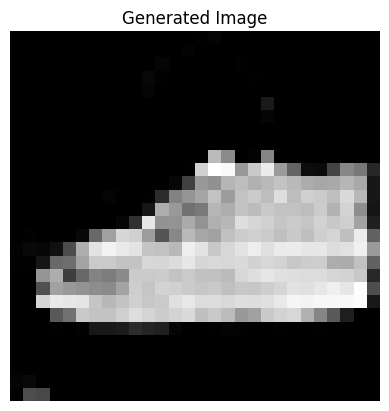

  0%|          | 20/5000 [00:00<00:24, 205.87it/s]


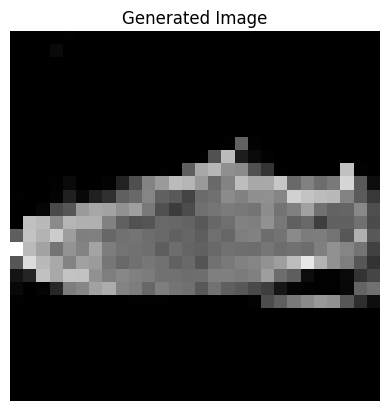

  0%|          | 20/5000 [00:00<00:21, 227.21it/s]


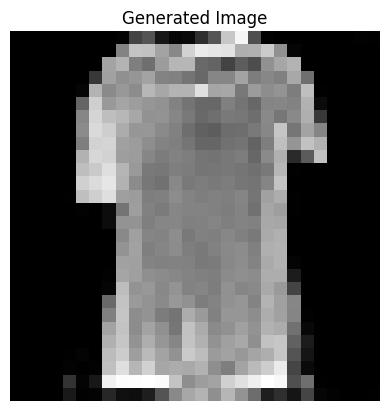

  0%|          | 20/5000 [00:00<00:20, 248.63it/s]


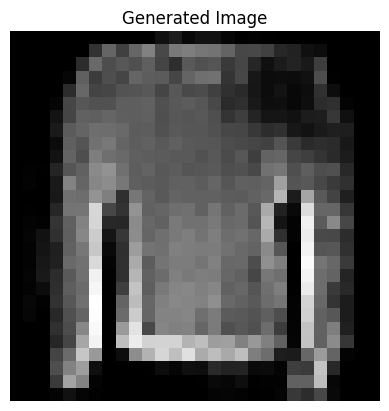

  0%|          | 20/5000 [00:00<00:21, 227.27it/s]


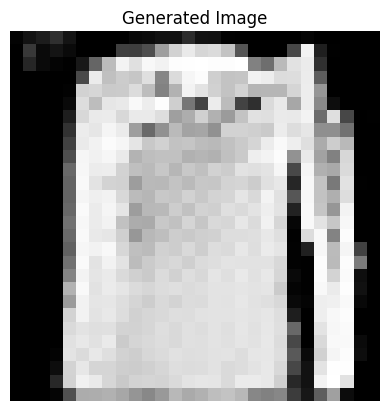

  0%|          | 20/5000 [00:00<00:19, 249.25it/s]


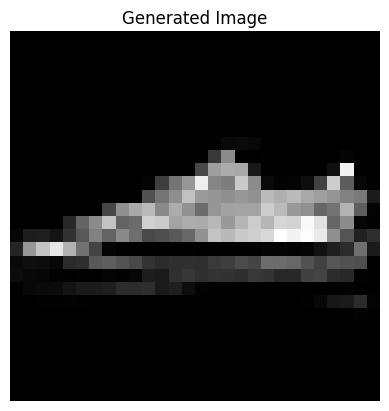

  0%|          | 20/5000 [00:00<00:20, 244.25it/s]


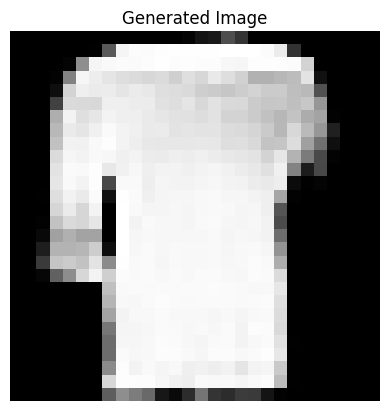

  0%|          | 20/5000 [00:00<00:21, 235.17it/s]


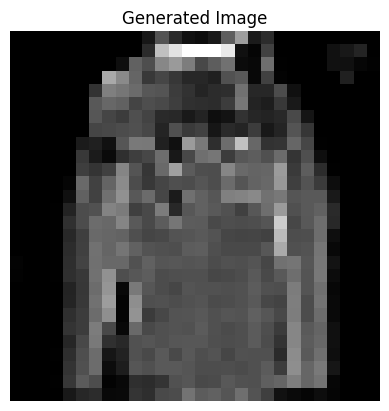

  0%|          | 20/5000 [00:00<00:21, 230.12it/s]


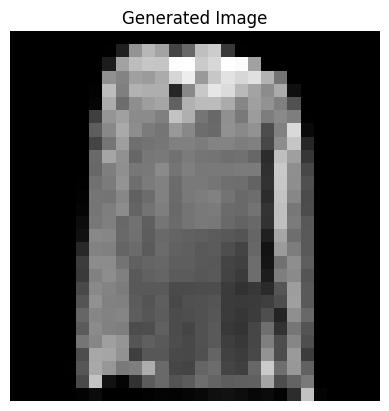

  0%|          | 20/5000 [00:00<00:23, 210.48it/s]


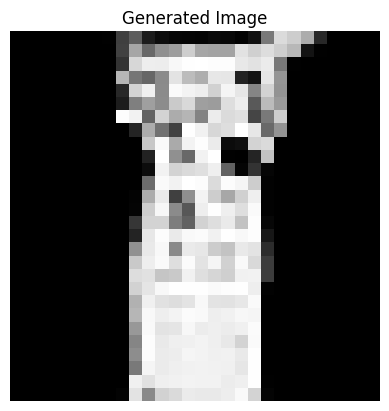

  0%|          | 20/5000 [00:00<00:19, 259.75it/s]


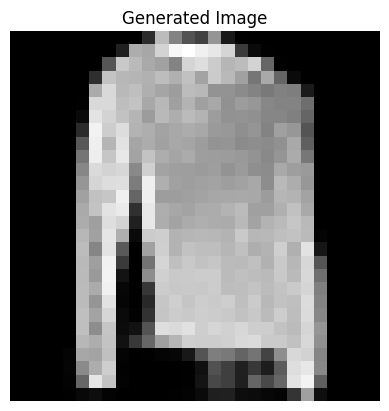

  0%|          | 20/5000 [00:00<00:19, 249.47it/s]


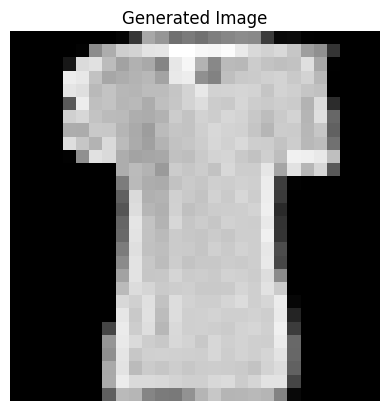

  0%|          | 20/5000 [00:00<00:23, 214.15it/s]


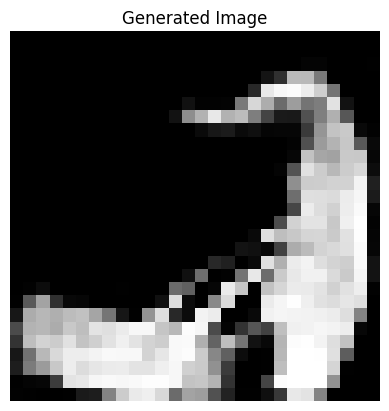

  0%|          | 20/5000 [00:00<00:20, 246.16it/s]


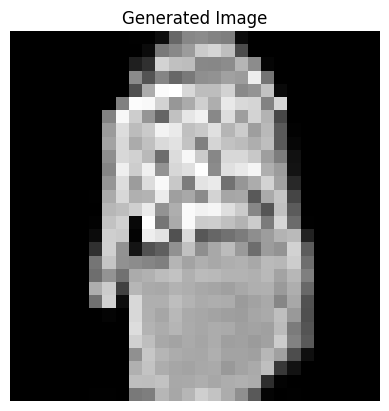

  0%|          | 20/5000 [00:00<00:19, 254.67it/s]


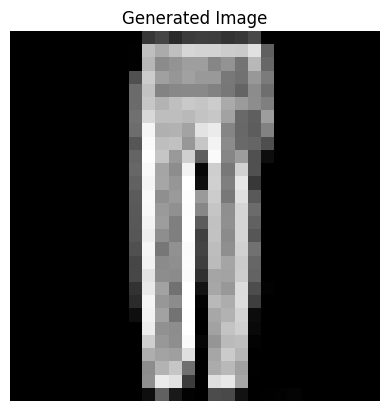

  0%|          | 20/5000 [00:00<00:21, 230.72it/s]


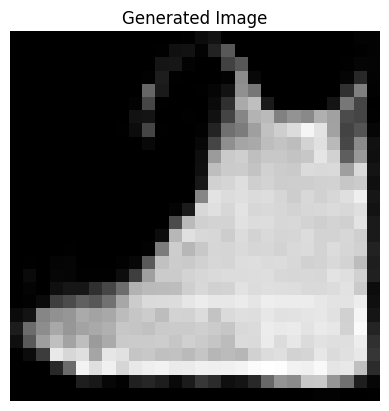

  0%|          | 20/5000 [00:00<00:19, 259.00it/s]


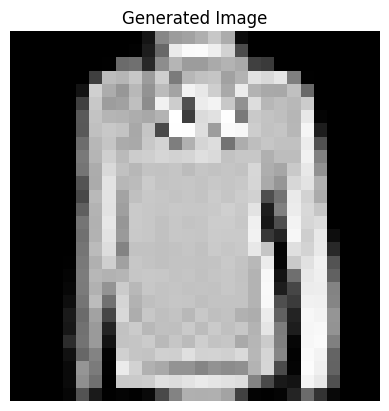

  0%|          | 20/5000 [00:00<00:18, 268.20it/s]


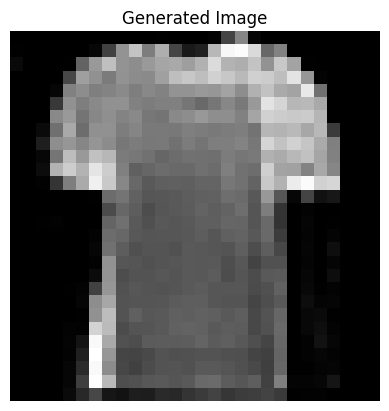

  0%|          | 20/5000 [00:00<00:20, 248.21it/s]


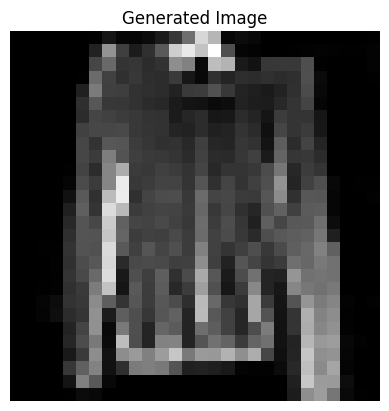

  0%|          | 20/5000 [00:00<00:19, 251.65it/s]


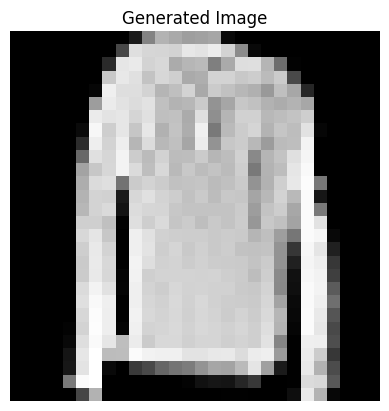

  0%|          | 20/5000 [00:00<00:22, 219.08it/s]


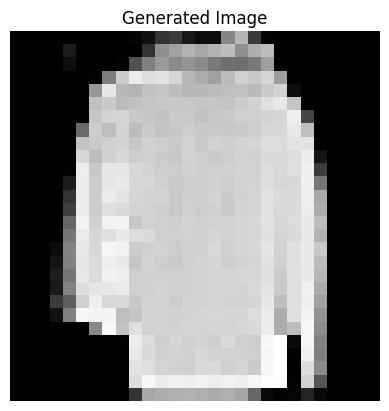

  0%|          | 20/5000 [00:00<00:21, 232.56it/s]


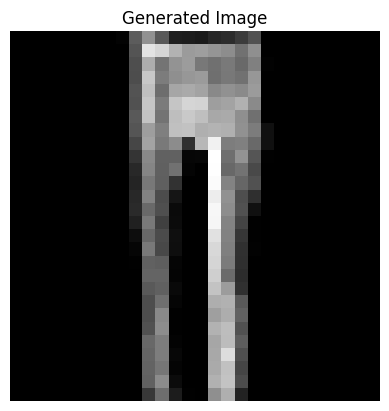

  0%|          | 20/5000 [00:00<00:23, 210.78it/s]


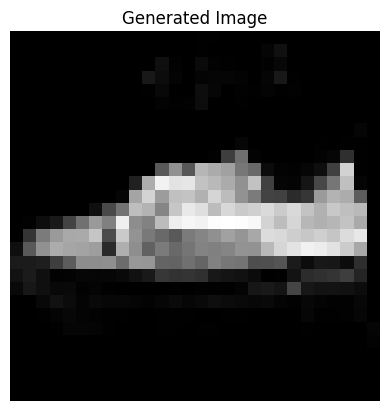

Epoch: 49:  19%|█▉        | 361/1875 [00:13<00:54, 27.61it/s, generator_loss=0.9553, descriminator_loss=0.5921]


KeyboardInterrupt: 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(latent_dim=512, device=device)
descriminator = Descriminator()


train(generator=generator, descriminator=descriminator, num_epochs=100, eval_epoch=20, device=device, batch_size=32)